In [2]:
import os
import json
import networkx as nx
from typing import Dict, Any, List
import json


In [3]:
os.environ["NEBIUS_API_KEY"] = "xxx"

In [4]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)

In [5]:
import fitz  # PyMuPDF
import re

def load_pdf(file_path):
    """
    Load and extract text from a PDF file.

    Args:
        file_path (str): Path to the PDF file.

    Returns:
        str: Cleaned text extracted from the PDF.
    """
    try:
        doc = fitz.open(file_path)  # Open the PDF
        text = ""
        for page in doc:
            text += page.get_text("text")  # Extract clean text
        cleaned_text = preprocess_text(text)
        return cleaned_text
    except Exception as e:
        print(f"Error loading PDF: {e}")
        return None

def preprocess_text(text):
    """
    Preprocess extracted text to remove unwanted characters.

    Args:
        text (str): Raw extracted text.

    Returns:
        str: Cleaned text.
    """
    text = re.sub(r'<\s*EOS\s*>', '', text)  # Remove <EOS> tokens
    text = re.sub(r'<\s*pad\s*>', '', text)  # Remove <pad> tokens
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = text.strip()  # Strip leading and trailing spaces
    return text

# Test with a PDF file
pdf_path = r"/Users/vivekrayalu/Desktop/Winter 2025/DSC 250/Attention.pdf"
text = load_pdf(pdf_path)

In [6]:
def call_llm_to_extract_metadata(paper_text):
    """
    Calls an LLM (Nebius) to extract metadata from the paper's text.
    
    Args:
        paper_text (str): Extracted text from the PDF.

    Returns:
        str: Raw JSON string response from the LLM.
    """
    try:
        system_content = (
            "You are an assistant that extracts structured metadata from academic paper text. Don't leave out any information. Make sure the References you extract from each paper are exhaustive and you find and output all."
            "Return the result in JSON format with these fields:\n"
            "- Title\n"
            "- Authors\n"
            "- Year\n"
            "- Abstract\n"
            "- Topics\n"
            "- References (Every reference with titles and authors of cited works)\n"
            "Ensure the output is a valid JSON object."
        )

        user_content = (
            f"Here is the paper text:\n\n{paper_text}\n\n"
            "Extract the metadata and return a structured JSON response."
        )

        response = client.chat.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct",
            temperature=0.0,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content}
            ]
        )

        # Extract raw content from LLM response
        raw_json_response = response.choices[0].message.content.strip()

        return raw_json_response

    except Exception as e:
        print(f"Error in LLM metadata extraction: {e}")
        return ""



In [37]:
pdf_text = load_pdf("/Users/vivekrayalu/Desktop/Winter 2025/DSC 250/Attention.pdf")
metadata = call_llm_to_extract_metadata(pdf_text)

metadata

'Here is the extracted metadata in JSON format:\n\n```json\n{\n  "Title": "Attention Is All You Need",\n  "Authors": [\n    "Ashish Vaswani",\n    "Noam Shazeer",\n    "Niki Parmar",\n    "Jakob Uszkoreit",\n    "Llion Jones",\n    "Aidan N. Gomez",\n    "Lukasz Kaiser",\n    "Illia Polosukhin"\n  ],\n  "Year": 2017,\n  "Abstract": "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.",\n  "Topics": [\n    "Neural Machine Translation",\n    "Sequence Transduction",\n    "Attention Mechanisms",\n    "Deep Learning"\n  ],\n  "References": [\n    {\n      "Title": "Layer normalization",\n      "Authors": ["Jimmy Lei Ba", "Jamie Ryan Kiros", "Geoffrey E

In [40]:
metadata

'Here is the extracted metadata in JSON format:\n\n```json\n{\n  "Title": "Attention Is All You Need",\n  "Authors": [\n    "Ashish Vaswani",\n    "Noam Shazeer",\n    "Niki Parmar",\n    "Jakob Uszkoreit",\n    "Llion Jones",\n    "Aidan N. Gomez",\n    "Lukasz Kaiser",\n    "Illia Polosukhin"\n  ],\n  "Year": 2017,\n  "Abstract": "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.",\n  "Topics": [\n    "Neural Machine Translation",\n    "Sequence Transduction",\n    "Attention Mechanisms",\n    "Deep Learning"\n  ],\n  "References": [\n    {\n      "Title": "Layer normalization",\n      "Authors": ["Jimmy Lei Ba", "Jamie Ryan Kiros", "Geoffrey E

In [7]:
papers_metadata = {}

def extract_json_from_response(raw_response):
    """
    Extracts and formats JSON from an LLM response that may contain Markdown formatting.
    Stores extracted metadata in a dictionary with an index-based key.

    Args:
        raw_response (str): Raw string response from the LLM.

    Returns:
        dict: Parsed JSON data.
    """
    try:
        # Extract JSON from markdown block
        match = re.search(r'```json\n(.*?)\n```', raw_response, re.DOTALL)
        json_text = match.group(1) if match else raw_response  # Extract JSON part

        # Convert to dictionary
        metadata = json.loads(json_text)

        # Generate a unique key based on the current number of papers
        paper_index = len(papers_metadata)  # Use index as key

        # Store metadata in the dictionary
        papers_metadata[paper_index] = metadata

        return metadata

    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return


In [42]:
extract_json_from_response(metadata)

{'Title': 'Attention Is All You Need',
 'Authors': ['Ashish Vaswani',
  'Noam Shazeer',
  'Niki Parmar',
  'Jakob Uszkoreit',
  'Llion Jones',
  'Aidan N. Gomez',
  'Lukasz Kaiser',
  'Illia Polosukhin'],
 'Year': 2017,
 'Abstract': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.',
 'Topics': ['Neural Machine Translation',
  'Sequence Transduction',
  'Attention Mechanisms',
  'Deep Learning'],
 'References': [{'Title': 'Layer normalization',
   'Authors': ['Jimmy Lei Ba', 'Jamie Ryan Kiros', 'Geoffrey E Hinton'],
   'Year': 2016},
  {'Title': 'Neural machine translation by jointly learning to align and translate',
   'Authors': ['Dzmitry Bahd

In [43]:
papers_metadata

{0: {'Title': 'Attention Is All You Need',
  'Authors': ['Ashish Vaswani',
   'Noam Shazeer',
   'Niki Parmar',
   'Jakob Uszkoreit',
   'Llion Jones',
   'Aidan N. Gomez',
   'Lukasz Kaiser',
   'Illia Polosukhin'],
  'Year': 2017,
  'Abstract': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.',
  'Topics': ['Neural Machine Translation',
   'Sequence Transduction',
   'Attention Mechanisms',
   'Deep Learning'],
  'References': [{'Title': 'Layer normalization',
    'Authors': ['Jimmy Lei Ba', 'Jamie Ryan Kiros', 'Geoffrey E Hinton'],
    'Year': 2016},
   {'Title': 'Neural machine translation by jointly learning to align and translate',
    'A

In [8]:
# Extracting metadata for other papers

pdf_folder = "/Users/vivekrayalu/Desktop/Winter 2025/DSC 250/"

# List of PDF filenames from the screenshot
pdf_files = [
    "Attention.pdf",
    "Neural Machine Translation.pdf",
    "Layer Normalization.pdf",
    # "Language Models are few shot.pdf",
    "Bert-pre-training.pdf"
]

# Loop through the PDFs and extract metadata
for idx, pdf_file in enumerate(pdf_files):
    file_path = os.path.join(pdf_folder, pdf_file)
    
    print(f"\nProcessing ({idx}): {pdf_file}")
    
    # Extract text from PDF
    pdf_text = load_pdf(file_path)
    
    # Call LLM to extract metadata
    metadata = call_llm_to_extract_metadata(pdf_text)
    
    # Extract and store metadata in dictionary
    extract_json_from_response(metadata)

print("\nMetadata extraction complete!")


Processing (0): Attention.pdf

Processing (1): Neural Machine Translation.pdf

Processing (2): Layer Normalization.pdf

Processing (3): Bert-pre-training.pdf

Metadata extraction complete!


In [52]:
pdf_text = load_pdf("/Users/vivekrayalu/Desktop/Winter 2025/DSC 250/Neural Machine Translation.pdf")
metadata = call_llm_to_extract_metadata(pdf_text)


In [53]:
metadata

'Here is the extracted metadata in JSON format:\n\n```json\n{\n  "Title": "Neural Machine Translation by Jointly Learning to Align and Translate",\n  "Authors": [\n    "Dzmitry Bahdanau",\n    "KyungHyun Cho",\n    "Yoshua Bengio"\n  ],\n  "Year": 2015,\n  "Abstract": "Neural machine translation is a recently proposed approach to machine translation. Unlike the traditional statistical machine translation, the neural machine translation aims at building a single neural network that can be jointly tuned to maximize the translation performance.",\n  "Topics": [\n    "Neural Machine Translation",\n    "Machine Learning",\n    "Natural Language Processing"\n  ],\n  "References": [\n    {\n      "Authors": "Axelrod, A., He, X., and Gao, J.",\n      "Title": "Domain adaptation via pseudo in-domain data selection",\n      "Year": 2011\n    },\n    {\n      "Authors": "Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I. J., Bergeron, A., Bouchard, N., and Bengio, Y.",\n      "Ti

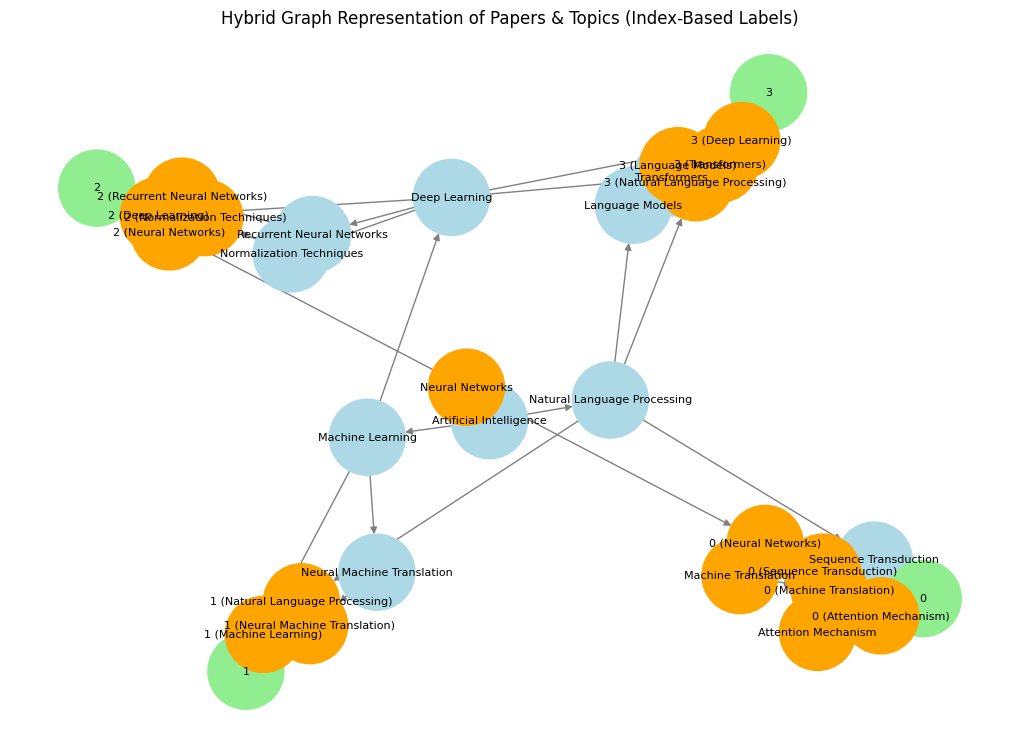

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define the hierarchical structure for topics
topic_hierarchy = {
    "Artificial Intelligence": ["Machine Learning", "Natural Language Processing"],
    "Machine Learning": ["Deep Learning", "Neural Machine Translation"],
    "Deep Learning": ["Transformers", "Recurrent Neural Networks", "Normalization Techniques"],
    "Natural Language Processing": ["Language Models", "Sequence Transduction"],
    "Transformers": [],
    "Neural Machine Translation": [],
    "Recurrent Neural Networks": [],
    "Normalization Techniques": [],
    "Sequence Transduction": [],
    "Language Models": []
}

# Step 1: Add Topic Nodes & Topic Hierarchy Edges
for parent, children in topic_hierarchy.items():
    if parent not in G:
        G.add_node(parent, type="Topic")  # Ensure every topic node has a type
    for child in children:
        if child not in G:
            G.add_node(child, type="Topic")  # Make sure all children are also topics
        G.add_edge(parent, child, type="Topic Hierarchy")

# Step 2: Add Papers as Nodes & Topic-Specific Representations
paper_node_mapping = {}  # Dictionary to store paper title to index mapping

for paper_id, metadata in papers_metadata.items():
    paper_title = metadata["Title"]
    topics = metadata["Topics"]

    # Store mapping: Paper Title → Paper Index
    paper_node_mapping[paper_title] = paper_id  

    # Add Main Paper Node (with Index as Label)
    G.add_node(paper_id, type="Paper")  # Use `paper_id` instead of `paper_title`

    # Topic-Specific Paper Nodes
    for topic in topics:
        topic_paper_node = f"{paper_id} ({topic})"  # Use paper index instead of title
        G.add_node(topic_paper_node, type="Paper-Topic")
        G.add_edge(topic, topic_paper_node, type="Topic-to-Paper")
        G.add_edge(topic_paper_node, paper_id, type="Paper-Alias")

# Step 3: Ensure all nodes have a type (defaulting to "Unknown")
for node in G.nodes():
    if "type" not in G.nodes[node]:
        G.nodes[node]["type"] = "Unknown"

# Step 4: Visualizing Graph (Small Subset)
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)

# Assign Colors Based on Type
node_colors = [
    "lightblue" if G.nodes[n].get("type", "Unknown") == "Topic" else
    "lightgreen" if G.nodes[n].get("type", "Unknown") == "Paper" else
    "orange"  # Paper-Topic or unknown nodes
    for n in G.nodes()
]

edge_colors = [
    "red" if G.edges[e]["type"] == "Citation" else "gray" for e in G.edges()
]

# Modify Labels: Use Paper Index Instead of Title
labels = {
    node: str(node) if isinstance(node, int) else node 
    for node in G.nodes()
}

nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color=node_colors, font_size=8, edge_color=edge_colors)
plt.title("Hybrid Graph Representation of Papers & Topics (Index-Based Labels)")
plt.show()


# Citation Edge → "Paper A" → "Paper B" (Paper A cites Paper B).
# Topic Hierarchy Edge → "Machine Learning" → "Deep Learning".
# Topic-to-Paper Edge → "Deep Learning" → "Paper A (Deep Learning)".
# Paper-Alias Edge → Connects topic-specific representations of the same paper.

In [ ]:
# Light blue is "Topic" nodes
# Green nodes are "Paper" nodes

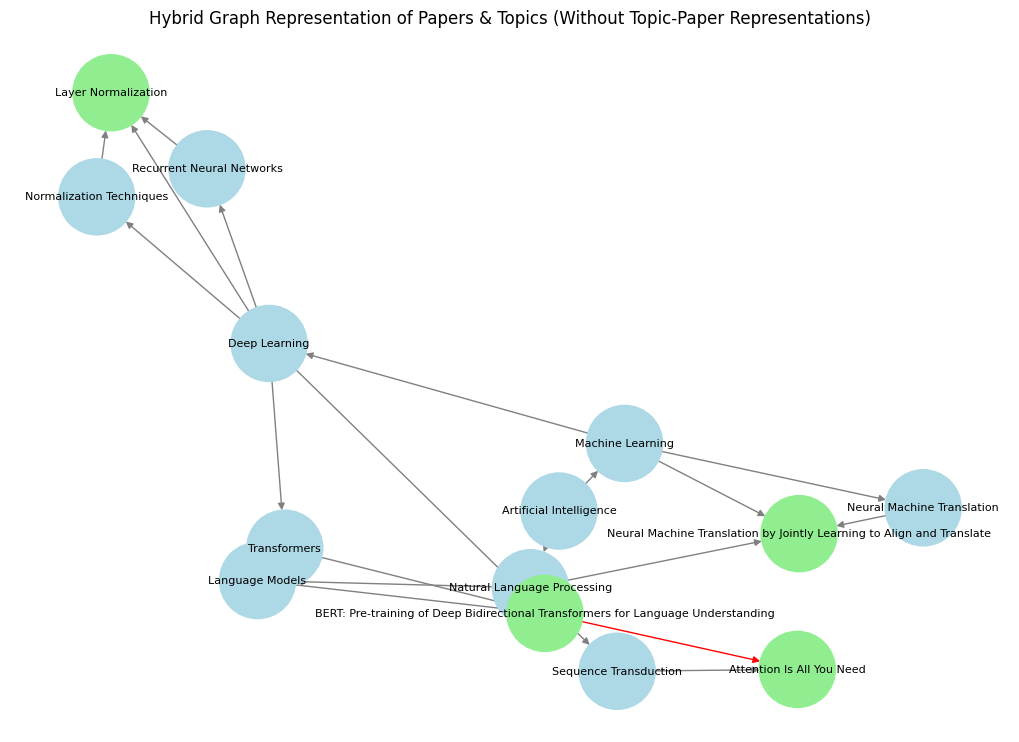

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define the hierarchical structure for topics
topic_hierarchy = {
    "Artificial Intelligence": ["Machine Learning", "Natural Language Processing"],
    "Machine Learning": ["Deep Learning", "Neural Machine Translation"],
    "Deep Learning": ["Transformers", "Recurrent Neural Networks", "Normalization Techniques"],
    "Natural Language Processing": ["Language Models", "Sequence Transduction"],
    "Transformers": [],
    "Neural Machine Translation": [],
    "Recurrent Neural Networks": [],
    "Normalization Techniques": [],
    "Sequence Transduction": [],
    "Language Models": []
}

# Step 1: Add Topic Nodes & Topic Hierarchy Edges
for parent, children in topic_hierarchy.items():
    G.add_node(parent, type="Topic")  # Ensure every topic node has a type
    for child in children:
        G.add_node(child, type="Topic")  # Make sure all children are also topics
        G.add_edge(parent, child, type="Topic Hierarchy")

# Step 2: Add Papers as Nodes & Link Directly to Topics
for paper_id, metadata in papers_metadata.items():
    paper_title = f"Paper {paper_id}"  # Use index instead of full title
    G.add_node(paper_id, type="Paper")

    for topic in metadata["Topics"]:
        if topic in G:
            G.add_edge(topic, paper_id, type="Topic-to-Paper")  # Direct link from topic to paper

# Step 3: Add Citation Edges (Paper A cites Paper B)
for paper_id, metadata in papers_metadata.items():
    for ref in metadata["References"]:
        ref_title = ref["Title"]
        ref_paper_id = next((key for key, val in papers_metadata.items() if val["Title"] == ref_title), None)
        if ref_paper_id is not None:  # Ensure the referenced paper exists in our dataset
            G.add_edge(paper_id, ref_paper_id, type="Citation")

# Step 4: Ensure all nodes have a type (defaulting to "Unknown")
for node in G.nodes():
    if "type" not in G.nodes[node]:
        G.nodes[node]["type"] = "Unknown"

# Step 5: Visualizing Graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)

# Assign Colors Based on Type
node_colors = [
    "lightblue" if G.nodes[n].get("type", "Unknown") == "Topic" else
    "lightgreen" if G.nodes[n].get("type", "Unknown") == "Paper" else
    "gray"  # Unknown or error cases
    for n in G.nodes()
]

edge_colors = [
    "red" if G.edges[e]["type"] == "Citation" else "gray" for e in G.edges()
]

# Uses Paper Index Instead of Title
labels = {
    node: str(node) if isinstance(node, int) else node  # Use index if node is a number
    for node in G.nodes()
}


# Run this if you want nodes with Paper title as label
# labels = {
#     node: papers_metadata[node]["Title"] if isinstance(node, int) and node in papers_metadata else node
#     for node in G.nodes()
# }

nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color=node_colors, font_size=8, edge_color=edge_colors)
plt.title("Hybrid Graph Representation of Papers & Topics (Without Topic-Paper Representations)")
plt.show()
